In [129]:
from run import retrieve_samples, retrieve_grid, retrieve_op, retrieve_model
import jax.numpy as jnp 
import jax.random as jr
import yaml
import scipy as sp 
import scipy.optimize 
from tqdm import tqdm 
from cheb import ChebInterpolator2D
import sklearn as sk
import sklearn.neighbors

cnf = '''dim: 2
gridpts: 20
prng_seed: 3621

train:
  truth:
      id: 'poisson-exA'
      data-noise: 0.01
      deriv-noise: 0.01
  samples:
    N: 100
    dist: 'uniform'
  reg:
    PINN: 1
    DATA: 1
    NORM: 1

model:
  id: "rbf"
  bandwidth: 1'''
cnf_template = yaml.safe_load(cnf)

cnf_template['key'] = jr.PRNGKey(cnf_template['prng_seed'])

Sample generation

In [6]:
class Dataset():
    def __init__(self, config, operator):
        self.config = config
        key = config['key']
        self.X_sample = retrieve_samples(config)
    
        _, _, dim_grid, W = retrieve_grid(config)
        self.Z_grid = dim_grid.reshape((-1, 2))
        self.Z_grid_weights = W
        
        self.N = len(self.X_sample)
        self.M = len(self.Z_grid)
        
        data_noise_var = config['train']['truth']['data-noise']
        pinn_noise_var = config['train']['truth']['deriv-noise']

        self.Y_sample = operator.eval_solution(self.X_sample)
        self.Y_sample_noisy = self.Y_sample + jnp.sqrt(data_noise_var) * jr.normal(key, shape=(self.N, 1))
        self.Y_grid = operator.eval_solution(self.Z_grid)
        self.R_grid = operator.eval_forcing(self.Z_grid)
        self.R_grid_noisy = self.R_grid + jnp.sqrt(pinn_noise_var) * jr.normal(key, shape=(self.M, 1))
        
def funcplot2d(grid, vals, res=100):
    K = sk.neighbors.KNeighborsRegressor(n_neighbors=8, weights='distance')
    K.fit(grid, vals)
    gridpts = jnp.stack(jnp.meshgrid(jnp.linspace(-1, 1, 100), jnp.linspace(-1, 1, 100)), axis=-1).reshape((-1, 2))
    vals = K.predict(gridpts)
    plt.imshow(vals.reshape(res, res))
    
    
    

In [158]:
from collections import defaultdict 

def linear_diagnostics(dataset, kernel, config, param_overwrite=None, verbose=False):
    X = dataset.X_sample
    Y = dataset.Y_sample_noisy
    Z = dataset.Z_grid
    R = dataset.R_grid_noisy
    W = dataset.Z_grid_weights
    
    Y_tru = dataset.Y_grid
    R_tru = dataset.R_grid

    Kxx = kernel.K(X, X)
    Hxz = kernel.H(X, Z)
    Gzz = kernel.G(Z, Z)
    Kzz = kernel.K(Z, Z)
    Kxz = kernel.K(X, Z)
    Hzz = kernel.H(Z, Z)
    Hxz = kernel.H(X, Z)
    Gzz = kernel.G(Z, Z)
    
    gma = config['train']['reg']['DATA']
    rho = config['train']['reg']['PINN']
    eta = config['train']['reg']['NORM']
    bdw = config['model']['bandwidth']
    N = dataset.N
    M = dataset.M
    
    results = []
    if param_overwrite is None: 
        cnfs = [(gma, rho, eta, bdw, N, M)]
    else:
        l = lambda a, b: [a] if len(b)==0 else b # this is stupid
        _param_overwrite = defaultdict(list, param_overwrite) # this is stupid
        cnfs = [(_gma, _rho, _eta, _bdw, _N, _M) for _gma in l(gma, _param_overwrite['gma'])
                                       for _rho in l(rho, _param_overwrite['rho'])
                                       for _eta in l(eta, _param_overwrite['eta'])
                                       for _bdw in l(bdw, _param_overwrite['bdw'])
                                       for _N in l(N, _param_overwrite['N'])
                                       for _M in l(M, _param_overwrite['M'])]        
    
    if verbose: 
        pbar = tqdm(total=len(cnfs))
        
    for (gma, rho, eta, bdw, N, M) in cnfs: 
        def _pile(_eta):
            cov_block = jnp.block( [  [Kxx + (gma/_eta) * jnp.eye(N), Hxz],
                                      [Hxz.T, Gzz + (rho * M / _eta) * jnp.diag(W)]])
            obs_block = jnp.concatenate( (Y, R), axis=0)

            obs_block_inv = jnp.linalg.lstsq(cov_block, obs_block)[0]

            _norm = (0.5 / _eta) * jnp.sum(obs_block * obs_block_inv)
            _det = 0.5 * jnp.linalg.slogdet(cov_block)[1] + (N+M) * 0.5 * jnp.log(2 * jnp.pi * _eta)
            return (_norm + _det) / (N+M)
        
        def _diagnostics(_eta):
            cov_block = jnp.block( [  [Kxx + (gma/_eta) * jnp.eye(N), Hxz],
                                      [Hxz.T, Gzz + (rho * M / _eta) * jnp.diag(W)]])
            obs_block = jnp.concatenate( (Y, R), axis=0)
            tru_block = jnp.concatenate( (Y_tru, R_tru), axis=0)
            
            obs_block_inv = jnp.linalg.lstsq(cov_block, obs_block)[0] 
            
            # compute PILE 
            _norm = (0.5 / _eta) * jnp.sum(obs_block * obs_block_inv)
            _det = 0.5 * jnp.linalg.slogdet(cov_block)[1] + (N+M) * 0.5 * jnp.log(2 * jnp.pi * _eta)
            PILE = (_norm + _det) / (N+M)
            
            # compute posterior generalization error
            cov_block_cross = jnp.block([  [Kxz.T, Hzz],
                                           [Hxz.T, Gzz.T ]]) # Gzz.T is redundant - it's here to match the math and avoid issues if I generalize this impl
            cov_block_grid = jnp.block( [  [Kzz, Hzz], [Hzz.T, Gzz] ] )
            cov_block_var_reduction = cov_block_cross @ jnp.linalg.lstsq(cov_block, cov_block_cross.T)[0]
            
            m_ppd = cov_block_cross @ obs_block_inv
            S_ppd = _eta * (cov_block_grid - cov_block_var_reduction)
            
            sq_errs = ((m_ppd - tru_block)**2).flatten() + jnp.diag(S_ppd)
            data_err = jnp.sum(W*sq_errs[:M])
            phys_err = jnp.sum(W*sq_errs[M:])
            
            return PILE, _det, _norm, data_err, phys_err, m_ppd, S_ppd
            
            
        # compute generalization error here 
        if eta == 0:
            res = sp.optimize.minimize_scalar(lambda x: _pile(x), bounds=(1, 5*(M+N)), method="bounded", options={"maxiter": 50}) 
            eta = res['x']
            
        PILE, _det, _norm, data_err, phys_err, m_ppd, S_ppd = _diagnostics(eta)
        results.append({'gma': gma, 'rho': rho, 'eta': eta, 'bandwidth': bdw, 'N': N, 'M': M, 'PILE': PILE,
                        'PILE_det': _det, 'PILE_norm': _norm, 'phys_err': phys_err, 'data_err': data_err, 
                        'm_ppd': m_ppd, 'S_ppd': S_ppd})
        if verbose:
            pbar.update(1)
    
    if param_overwrite is None:
        return results[0]
    else:
        return results



In [22]:
operator = retrieve_op(cnf_template)
kernel = retrieve_model(cnf_template)
dataset = Dataset(cnf_template, operator)

# PILE and rho

In [ ]:
import matplotlib.pyplot as plt 

X = jnp.geomspace(0.0005, 0.2, 100)
res_rho_xs = linear_diagnostics(dataset, kernel, cnf_template, param_overwrite={'eta': [0.1], 'rho': X}, verbose=True)
res_rho_sm = linear_diagnostics(dataset, kernel, cnf_template, param_overwrite={'eta': [0.5], 'rho': X}, verbose=True)
res_rho_md = linear_diagnostics(dataset, kernel, cnf_template, param_overwrite={'eta': [1], 'rho': X}, verbose=True)
res_rho_lg = linear_diagnostics(dataset, kernel, cnf_template, param_overwrite={'eta': [1.5], 'rho': X}, verbose=True)

In [98]:
res_rho_opt = linear_diagnostics(dataset, kernel, cnf_template, param_overwrite={'eta': [0], 'rho': X[::5]}, verbose=True)


100%|██████████| 20/20 [01:13<00:00,  3.67s/it]


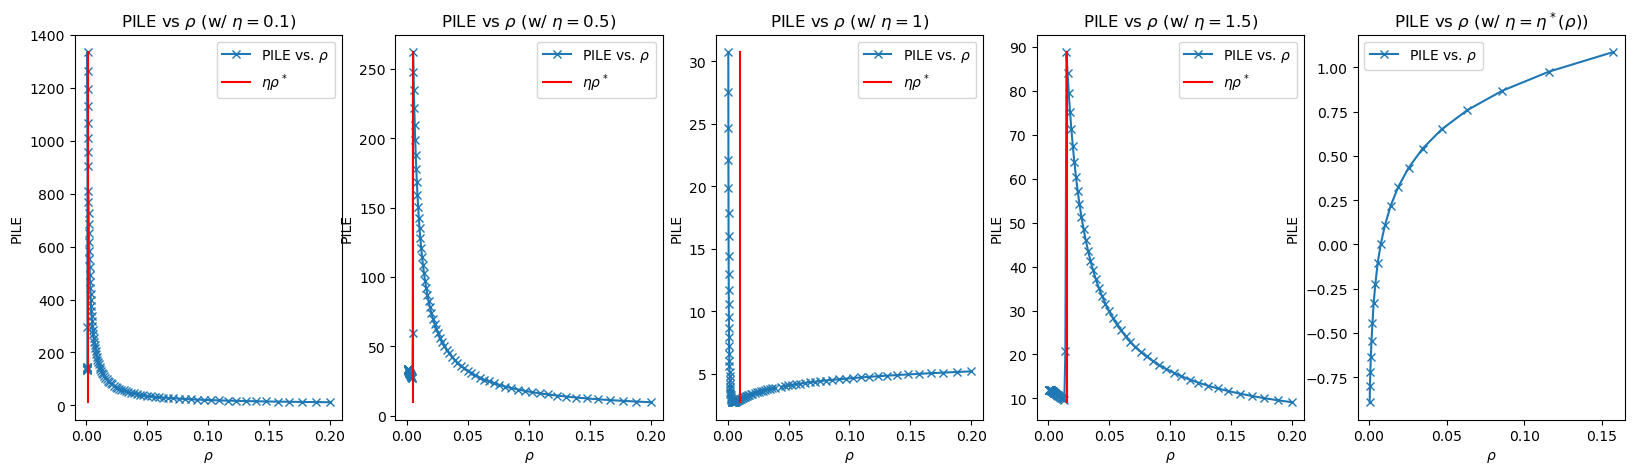

In [148]:
for i, (eta, res) in enumerate([(0.1, res_rho_xs), (0.5, res_rho_sm), (1, res_rho_md), (1.5, res_rho_lg)]):
    plt.subplot(1, 5, 1+i)
    Y = jnp.array([r['PILE'] for r in res])
    plt.plot(X, Y, 'x-', label="PILE vs. $\\rho$")
    plt.plot([0.01 * eta, 0.01 * eta], [jnp.nanmin(Y), jnp.nanmax(Y)], c="red", label='$\\eta \\rho^*$')
    plt.xlabel('$\\rho$')
    plt.ylabel('PILE')
    plt.title(f'PILE vs $\\rho$ (w/ $\eta={eta}$)')
    plt.legend()

plt.subplot(1, 5, 5)
Y = jnp.array([r['PILE'] for r in res_rho_opt])
plt.plot(X[::5], Y, 'x-', label="PILE vs. $\\rho$")
plt.xlabel('$\\rho$')
plt.ylabel('PILE')
plt.title(f'PILE vs $\\rho$ (w/ $\eta=\eta^*(\\rho)$)')
plt.legend()
plt.gcf().set_size_inches(20, 5)
plt.savefig('figures/PILE_vs_rho.pdf')
plt.show()

In [116]:
X = jnp.concatenate((jnp.geomspace(0.005, 1, 100), jnp.geomspace(1, 20, 100)))
res_rho_widerange = linear_diagnostics(dataset, kernel, cnf_template, param_overwrite={'eta': [1], 'rho': X}, verbose=True)

100%|██████████| 200/200 [00:28<00:00,  6.92it/s]


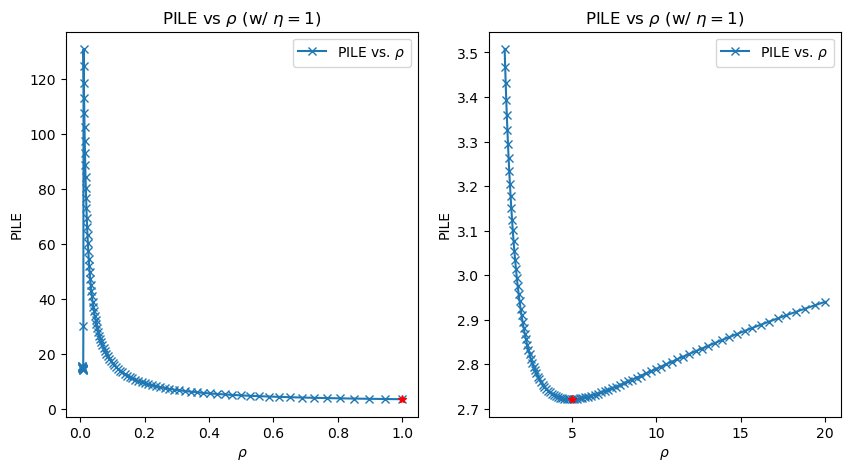

In [146]:
plt.subplot(1, 2, 1)
Y = jnp.array([r['PILE'] for r in res_rho_widerange[:100]])
plt.plot(X[:100], Y, 'x-', label="PILE vs. $\\rho$")
plt.plot([X[jnp.argmin(Y)]], [jnp.min(Y)], 'r*')
plt.xlabel('$\\rho$')
plt.ylabel('PILE')
plt.title(f'PILE vs $\\rho$ (w/ $\eta=1$)')
plt.legend()
plt.subplot(1, 2, 2)
Y = jnp.array([r['PILE'] for r in res_rho_widerange[100:]])
plt.plot(X[100:], Y, 'x-', label="PILE vs. $\\rho$")
plt.plot([X[100+jnp.argmin(Y)]], [jnp.min(Y)], 'r*')
plt.xlabel('$\\rho$')
plt.ylabel('PILE')
plt.title(f'PILE vs $\\rho$ (w/ $\eta=1$)')
plt.legend()
plt.gcf().set_size_inches(10, 5)
plt.savefig('figures/PILE_vs_rho_widerange.pdf')

# PILE and Gamma

In [ ]:
X = jnp.geomspace(0.0005, 0.2, 100)
res_gma_xs = linear_diagnostics(dataset, kernel, cnf_template, param_overwrite={'eta': [0.1], 'gma': X}, verbose=True)
res_gma_sm = linear_diagnostics(dataset, kernel, cnf_template, param_overwrite={'eta': [0.5], 'gma': X}, verbose=True)
res_gma_md = linear_diagnostics(dataset, kernel, cnf_template, param_overwrite={'eta': [1], 'gma': X}, verbose=True)
res_gma_lg = linear_diagnostics(dataset, kernel, cnf_template, param_overwrite={'eta': [1.5], 'gma': X}, verbose=True)
res_gma_opt = linear_diagnostics(dataset, kernel, cnf_template, param_overwrite={'eta': [0], 'gma': X[::5]},
                                 verbose=True)

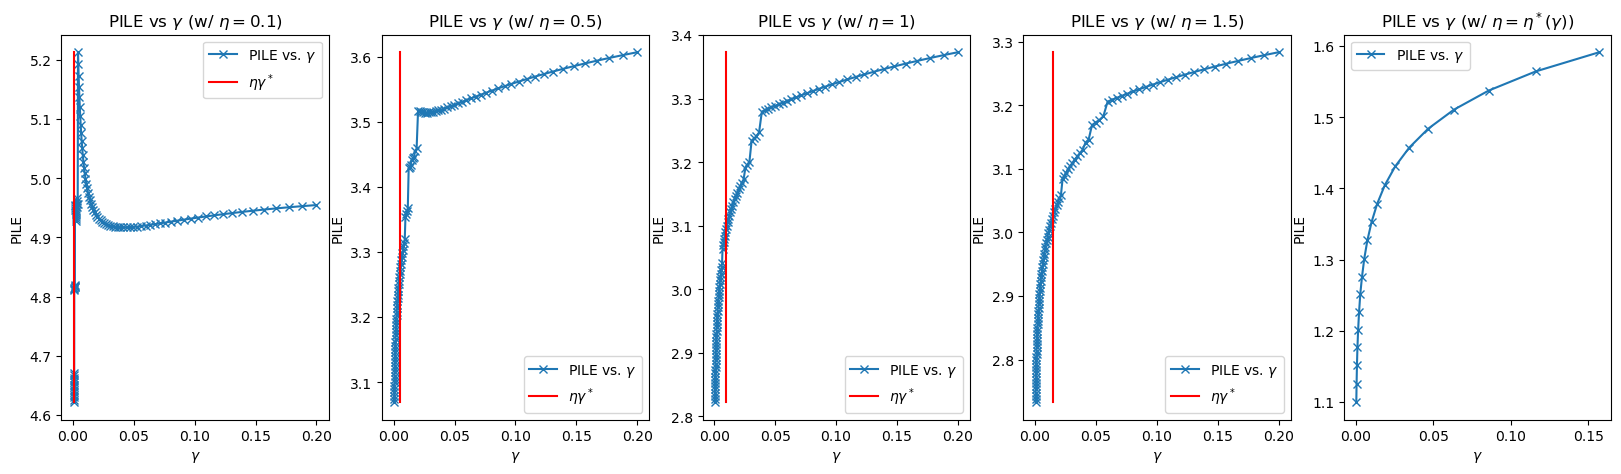

In [141]:

for i, (eta, res) in enumerate([(0.1, res_gma_xs), (0.5, res_gma_sm), (1, res_gma_md), (1.5, res_gma_lg)]):
    plt.subplot(1, 5, 1 + i)
    Y = jnp.array([r['PILE'] for r in res])
    plt.plot(X, Y, 'x-', label="PILE vs. $\\gamma$")
    plt.plot([0.01 * eta, 0.01 * eta], [jnp.nanmin(Y), jnp.nanmax(Y)], c="red", label='$\\eta \\gamma^*$')
    plt.xlabel('$\\gamma$')
    plt.ylabel('PILE')
    plt.title(f'PILE vs $\\gamma$ (w/ $\eta={eta}$)')
    plt.legend()

plt.subplot(1, 5, 5)
Y = jnp.array([r['PILE'] for r in res_gma_opt])
plt.plot(X[::5], Y, 'x-', label="PILE vs. $\\gamma$")
plt.xlabel('$\\gamma$')
plt.ylabel('PILE')
plt.title(f'PILE vs $\\gamma$ (w/ $\eta=\eta^*(\\gamma)$)')
plt.legend()
plt.gcf().set_size_inches(20, 5)
plt.savefig('figures/PILE_vs_gamma.pdf')
plt.show()


In [ ]:
X = jnp.concatenate((jnp.geomspace(0.0000005, 0.005, 100), jnp.geomspace(0.005, 1, 100), jnp.geomspace(1, 20, 100)))
res_gma_widerange = linear_diagnostics(dataset, kernel, cnf_template, param_overwrite={'eta': [1], 'gma': X},
                                       verbose=True)

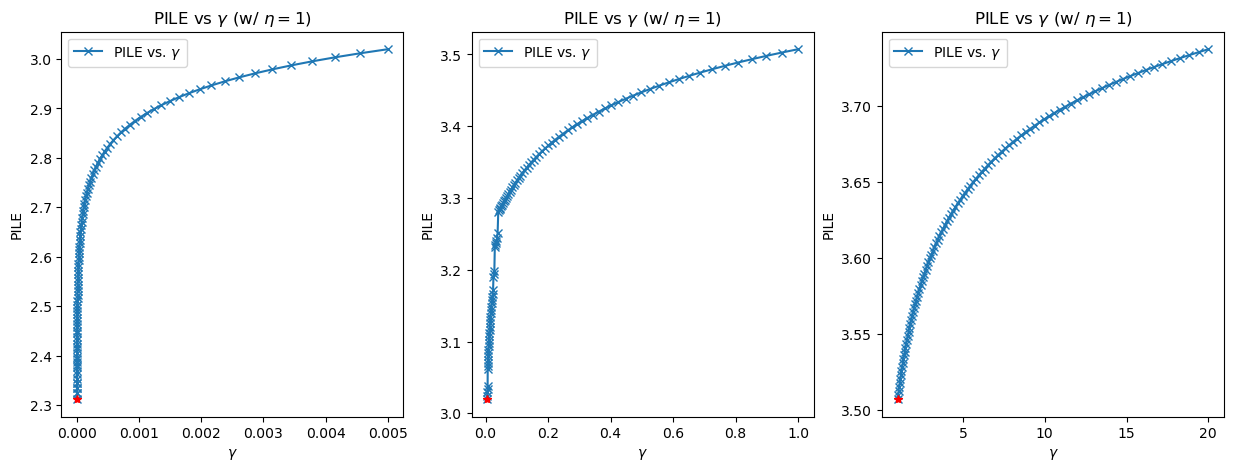

In [143]:

plt.subplot(1, 3, 1)
Y = jnp.array([r['PILE'] for r in res_gma_widerange[:100]])
plt.plot(X[:100], Y, 'x-', label="PILE vs. $\\gamma$")
plt.plot([X[jnp.argmin(Y)]], [jnp.min(Y)], 'r*')
plt.xlabel('$\\gamma$')
plt.ylabel('PILE')
plt.title(f'PILE vs $\\gamma$ (w/ $\eta=1$)')
plt.legend()
plt.subplot(1, 3, 2)
Y = jnp.array([r['PILE'] for r in res_gma_widerange[100:200]])
plt.plot(X[100:200], Y, 'x-', label="PILE vs. $\\gamma$")
plt.plot([X[100+jnp.argmin(Y)]], [jnp.min(Y)], 'r*')
plt.xlabel('$\\gamma$')
plt.ylabel('PILE')
plt.title(f'PILE vs $\\gamma$ (w/ $\eta=1$)')
plt.legend()
plt.subplot(1, 3, 3)
Y = jnp.array([r['PILE'] for r in res_gma_widerange[200:]])
plt.plot(X[200:], Y, 'x-', label="PILE vs. $\\gamma$")
plt.plot([X[200 + jnp.argmin(Y)]], [jnp.min(Y)], 'r*')
plt.xlabel('$\\gamma$')
plt.ylabel('PILE')
plt.title(f'PILE vs $\\gamma$ (w/ $\eta=1$)')
plt.legend()
plt.gcf().set_size_inches(15, 5)
plt.savefig('figures/PILE_vs_gamma_widerange.pdf')


## what about with larger sample sizes? 

In [ ]:
X = jnp.geomspace(0.0005, 0.2, 100)
cnf_template_n1000 = yaml.safe_load(cnf)
cnf_template_n1000['train']['samples']['N'] = 1000
cnf_template_n1000['key'] = jr.PRNGKey(cnf_template['prng_seed'])
dataset_n1000 = Dataset(cnf_template_n1000, operator)

res_gma_xs = linear_diagnostics(dataset_n1000, kernel, cnf_template, param_overwrite={'eta': [0.1], 'N': [1000], 'gma': X}, verbose=True)
res_gma_sm = linear_diagnostics(dataset_n1000, kernel, cnf_template, param_overwrite={'eta': [0.5], 'N': [1000], 'gma': X}, verbose=True)
res_gma_md = linear_diagnostics(dataset_n1000, kernel, cnf_template, param_overwrite={'eta': [1], 'N': [1000], 'gma': X}, verbose=True)
res_gma_lg = linear_diagnostics(dataset_n1000, kernel, cnf_template, param_overwrite={'eta': [1.5], 'N': [1000], 'gma': X}, verbose=True)
res_gma_opt = linear_diagnostics(dataset_n1000, kernel, cnf_template, param_overwrite={'eta': [0], 'N': [1000], 'gma': X[::5]},
                                 verbose=True)

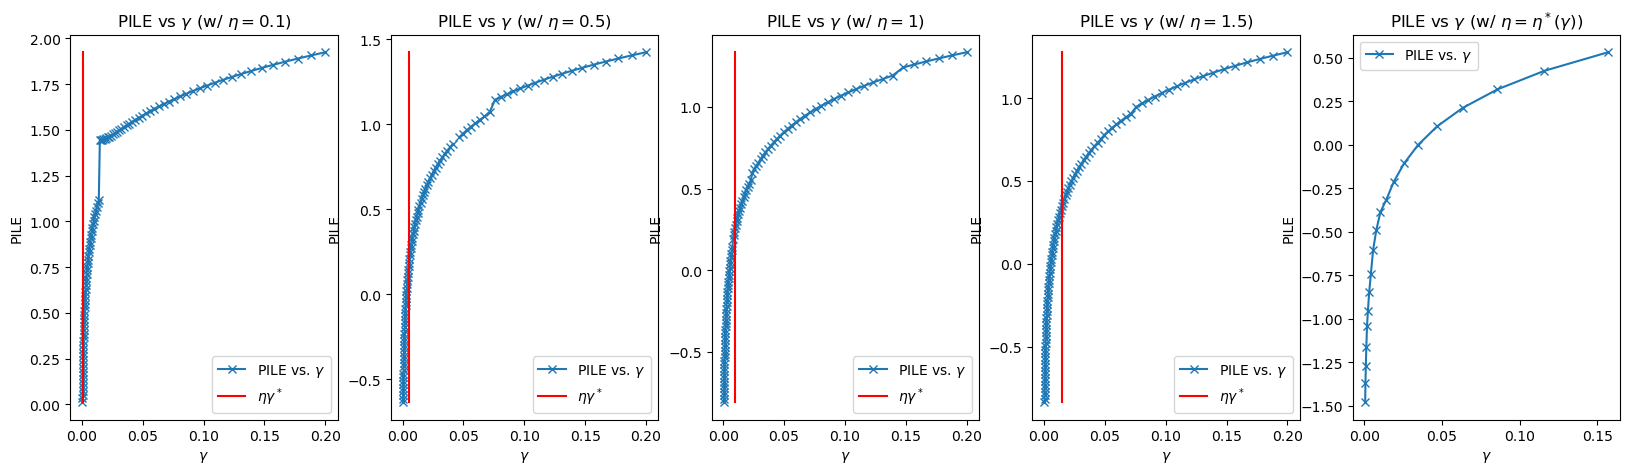

In [136]:

for i, (eta, res) in enumerate([(0.1, res_gma_xs), (0.5, res_gma_sm), (1, res_gma_md), (1.5, res_gma_lg)]):
    plt.subplot(1, 5, 1 + i)
    Y = jnp.array([r['PILE'] for r in res])
    plt.plot(X, Y, 'x-', label="PILE vs. $\\gamma$")
    plt.plot([0.01 * eta, 0.01 * eta], [jnp.nanmin(Y), jnp.nanmax(Y)], c="red", label='$\\eta \\gamma^*$')
    plt.xlabel('$\\gamma$')
    plt.ylabel('PILE')
    plt.title(f'PILE vs $\\gamma$ (w/ $\eta={eta}$)')
    plt.legend()

plt.subplot(1, 5, 5)
Y = jnp.array([r['PILE'] for r in res_gma_opt])
plt.plot(X[::5], Y, 'x-', label="PILE vs. $\\gamma$")
plt.xlabel('$\\gamma$')
plt.ylabel('PILE')
plt.title(f'PILE vs $\\gamma$ (w/ $\eta=\eta^*(\\gamma)$)')
plt.legend()
plt.gcf().set_size_inches(20, 5)
plt.savefig('figures/n=1000_PILE_vs_gamma.pdf', dpi=120)
plt.show()

# PILE Correlation with performance

In [149]:
dataset_n1000 = Dataset(cnf_template_n1000, operator)
res_grid_search = linear_diagnostics(dataset_n1000, kernel, cnf_template, param_overwrite={'eta': [1], 'N': [1000], 'rho': jnp.linspace(3, 8, 20), 'gma': jnp.geomspace(0.005, 0.5, 20)}, verbose=True)


100%|██████████| 400/400 [07:54<00:00,  1.19s/it]


In [152]:
piles = [r['PILE'] for r in res_grid_search]
data_errs = [r['data_err'] for r in res_grid_search]
phys_errs = [r['phys_err'] for r in res_grid_search]

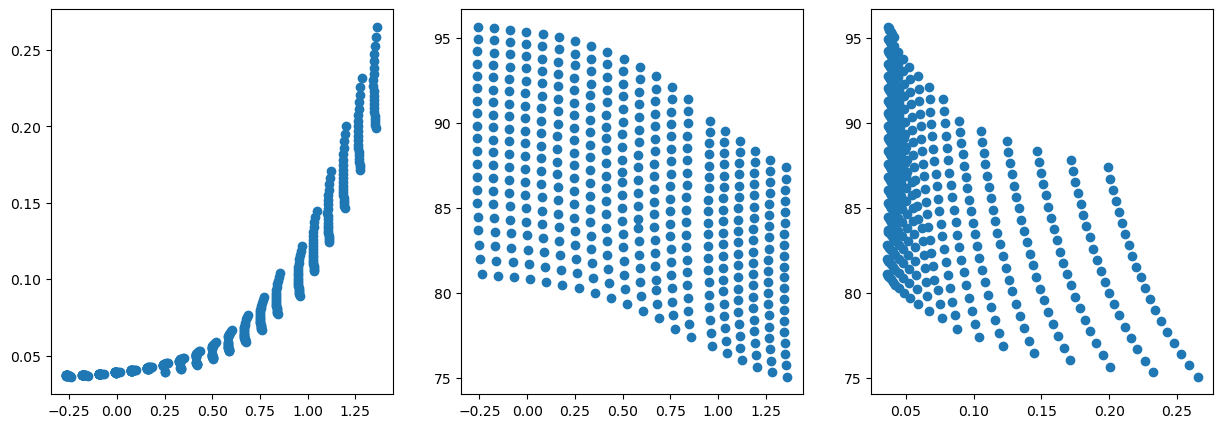

In [157]:
plt.subplot(1, 3, 1)
plt.scatter(piles, data_errs)
plt.subplot(1, 3, 2)
plt.scatter(piles, phys_errs)
plt.gcf().set_size_inches(10, 5)
plt.subplot(1, 3, 3)
plt.scatter(data_errs,phys_errs)
plt.gcf().set_size_inches(15, 5)
plt.show()